#**Bitcoin Predictions with ARIMA**

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
#importing libraries for dataframe and mathematical functions
import pandas as pd
from pandas import DataFrame
import numpy as np

#importing libraries for graphical representation
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns

#imported library for date,time variables
from datetime import datetime, timedelta

#importing libraries necessary for model creation
from statsmodels.tsa.arima_model import ARIMA                 #library for ARIMA model implementation
from statsmodels.tsa.statespace.sarimax import SARIMAX        #library for SARIMAX model implementation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #library imported for plotting ACG and PACF graphs
from statsmodels.tsa.stattools import adfuller                #library to compute with ADFuller test

#importing library for seasonal decomposition implementation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

#**Data Collection and Pre-processing**

In [120]:
#reading dates from the dataframe
parsedates = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#Reading CSV file
df = pd.read_csv('/content/crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=parsedates) 
df.head()
#[2]

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [121]:
df.tail()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2018-01-02,ocow,OCOW,OCOW,1516,0.000014,0.000030,0.000013,0.000015,733,0,0.1176,0.0
2018-01-03,ocow,OCOW,OCOW,1516,0.000015,0.000031,0.000015,0.000015,1200,0,0.0000,0.0
2018-01-04,ocow,OCOW,OCOW,1516,0.000015,0.000031,0.000015,0.000030,5375,0,0.9375,0.0
2018-01-05,ocow,OCOW,OCOW,1516,0.000030,0.000032,0.000016,0.000017,1922,0,0.0625,0.0
2018-01-06,ocow,OCOW,OCOW,1516,0.000017,0.000017,0.000016,0.000017,1884,0,1.0000,0.0


In [122]:
# need to extract data of bitcoin data only[1]
bc=df[df['symbol']=='BTC']
# dropping all the columns that are not necessary for the predictions work[1]
bc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True) 

In [123]:
bc.head()

,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


In [124]:
#resampling the data into monthly frequency[3]
bc_mth = bc.resample('M').mean()

#**Model Pre-processing**

## Stationarity check

Augmented Dickey Fuller(ADF) test result: p = 0.998818 


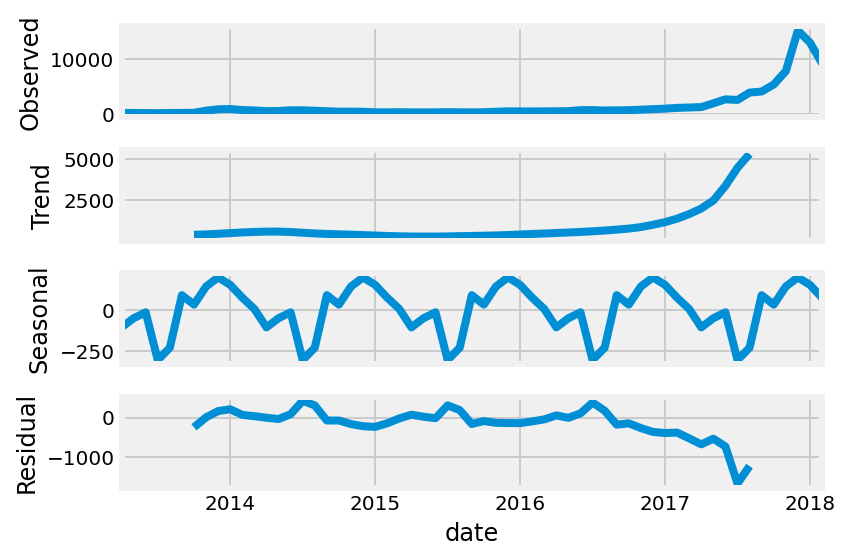

In [125]:
#first step towards model preprocessing phase
#as the seasonal_decompose library has been imported
#will be utilizing it for graphical representation of decomposition
seasonal_decompose(bc_mth.close).plot() #[3]
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f " % adfuller(bc_mth.close)[1])
plt.show()

As we know that value of p should not be greater than 0.05 for the series to be stationary. But since the p value is 0.998 which is greater than threshold. It can be said that the series is not stationary.

## Box-Cox Transformation

In [126]:
# implementing Box-Cox Transformations for normalization [3]
bc_mth['close_box'], lmbda = stats.boxcox(bc_mth.close)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p =%f" % adfuller(bc_mth.close_box)[1])

Augmented Dickey Fuller(ADF) test result: p =0.513639


The series is still not stationary.

## Differencing

###Seasonal differentiation

In [127]:
# creating new dataframe to compute monthly seasonal differentition for 12 months [3]
bc_mth['box_diff_seasonal_12'] = (bc_mth.close_box - bc_mth.close_box.shift(12))
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(bc_mth.box_diff_seasonal_12[12:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.666118


Series is still not stationary.




In [128]:
#creating new dataframe to compute monthly seasonal differentition for 3 months [3]
bc_mth['box_diff_seasonal_3'] = bc_mth.close_box - bc_mth.close_box.shift(3)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(bc_mth.box_diff_seasonal_3[3:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.017880


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

### Regular differentiation

To obtain a stationary time series, it may be necessary to difference the data a second time, which is known as second order differencing.

Augmented Dickey Fuller(ADF) test result: p = 0.002295


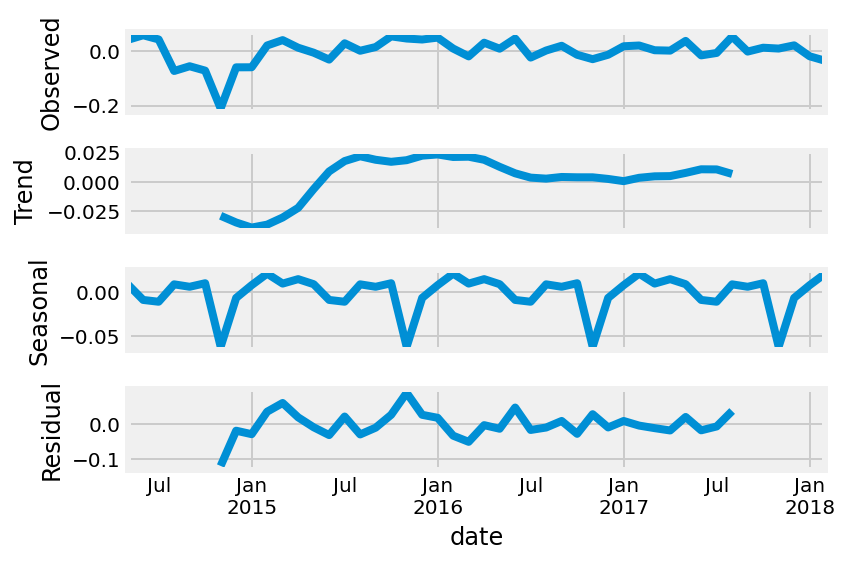

In [129]:
# #creating new dataframe to compute implement differentition for 12 months [3]
bc_mth['box_diff2'] = (bc_mth.box_diff_seasonal_12 - bc_mth.box_diff_seasonal_12.shift(1))

# Seasonal and Trend decomposition using Loess decomposition [3]
seasonal_decompose(bc_mth.box_diff2[13:]).plot()   
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(bc_mth.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05. 

### Autocorrelation

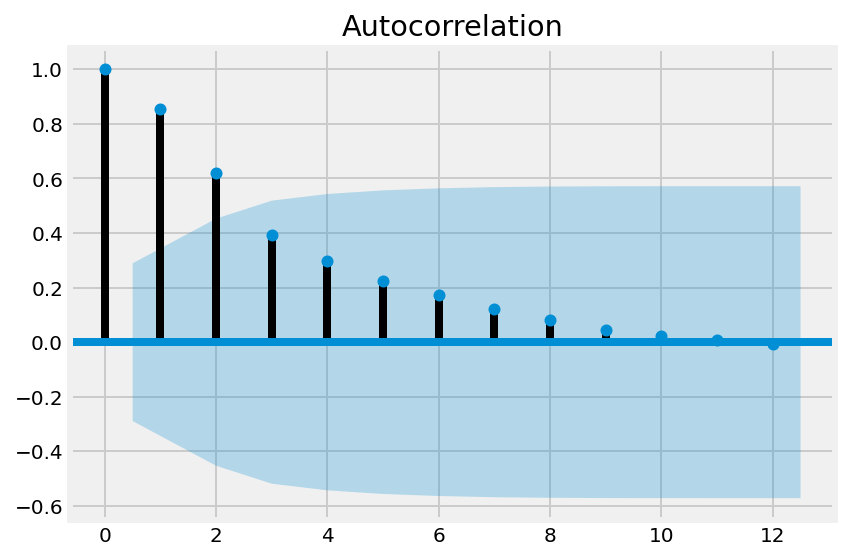

In [130]:
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_acf(bc_mth.close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

A positive correlation exists with the first 10 lags, which is possibly significant for the first 2-3 lags.

A good starting point for the model's AR parameter is 3.

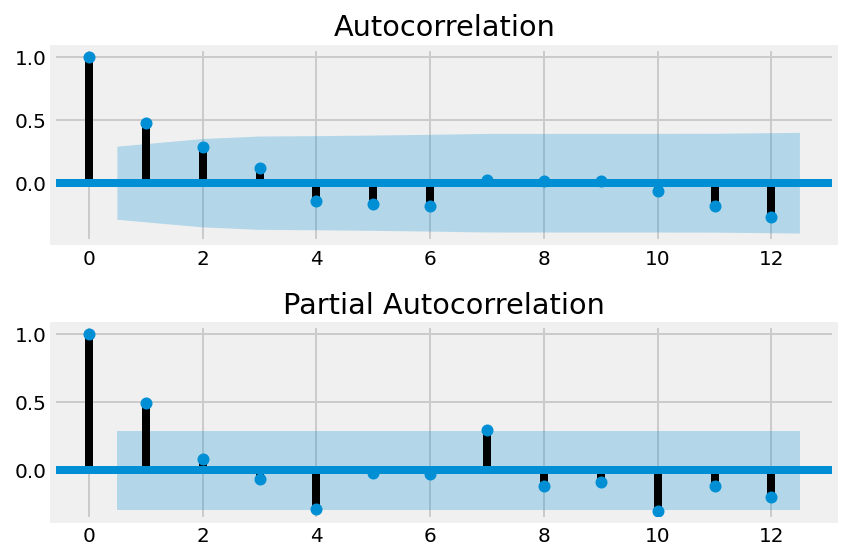

In [131]:
# Initial parameter approximation 
#PlottingAutocorrelation(ACF) and Partial Autocorrelation(PACF) Plots[3]
ax = plt.subplot(211)
# Plot the autocorrelation function [3]
plot_acf(bc_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_pacf(bc_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

# **Model Building**

##ARIMA Model
AutoRegressive Integrated Moving Average

#### Parameter Selection


In [132]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_bst:
        mdl_bst = model
        aic_bst = aic
        params_bst = param
    rslt.append([param, model.aic])

In [133]:
#printing the best suited results of the models[1]
#new dataframe to store the results of the appropriate models
rslt_table = pd.DataFrame(rslt)
#creating two columns to print values accordingly
rslt_table.columns = ['parameters', 'aic']
#sorting of values based into the relevant columns
print(rslt_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -221.187837
1     (0, 1) -220.803378
4     (1, 1) -219.227471
6     (2, 0) -219.218002
2     (0, 2) -219.002799


In [134]:
#representation of summary of appropriate ARIMA models[1]
print(mdl_bst.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   59
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 112.594
Date:                Sun, 14 Aug 2022   AIC                           -221.188
Time:                        22:08:49   BIC                           -217.067
Sample:                    04-30-2013   HQIC                          -219.583
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3737      0.151      2.471      0.013       0.077       0.670
sigma2         0.0012      0.000     11.243      0.000       0.001       0.001
Ljung-Box (Q):                       19.65   Jarque-

### Analysis of Results

In [135]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(mdl_bst.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p=0.005647


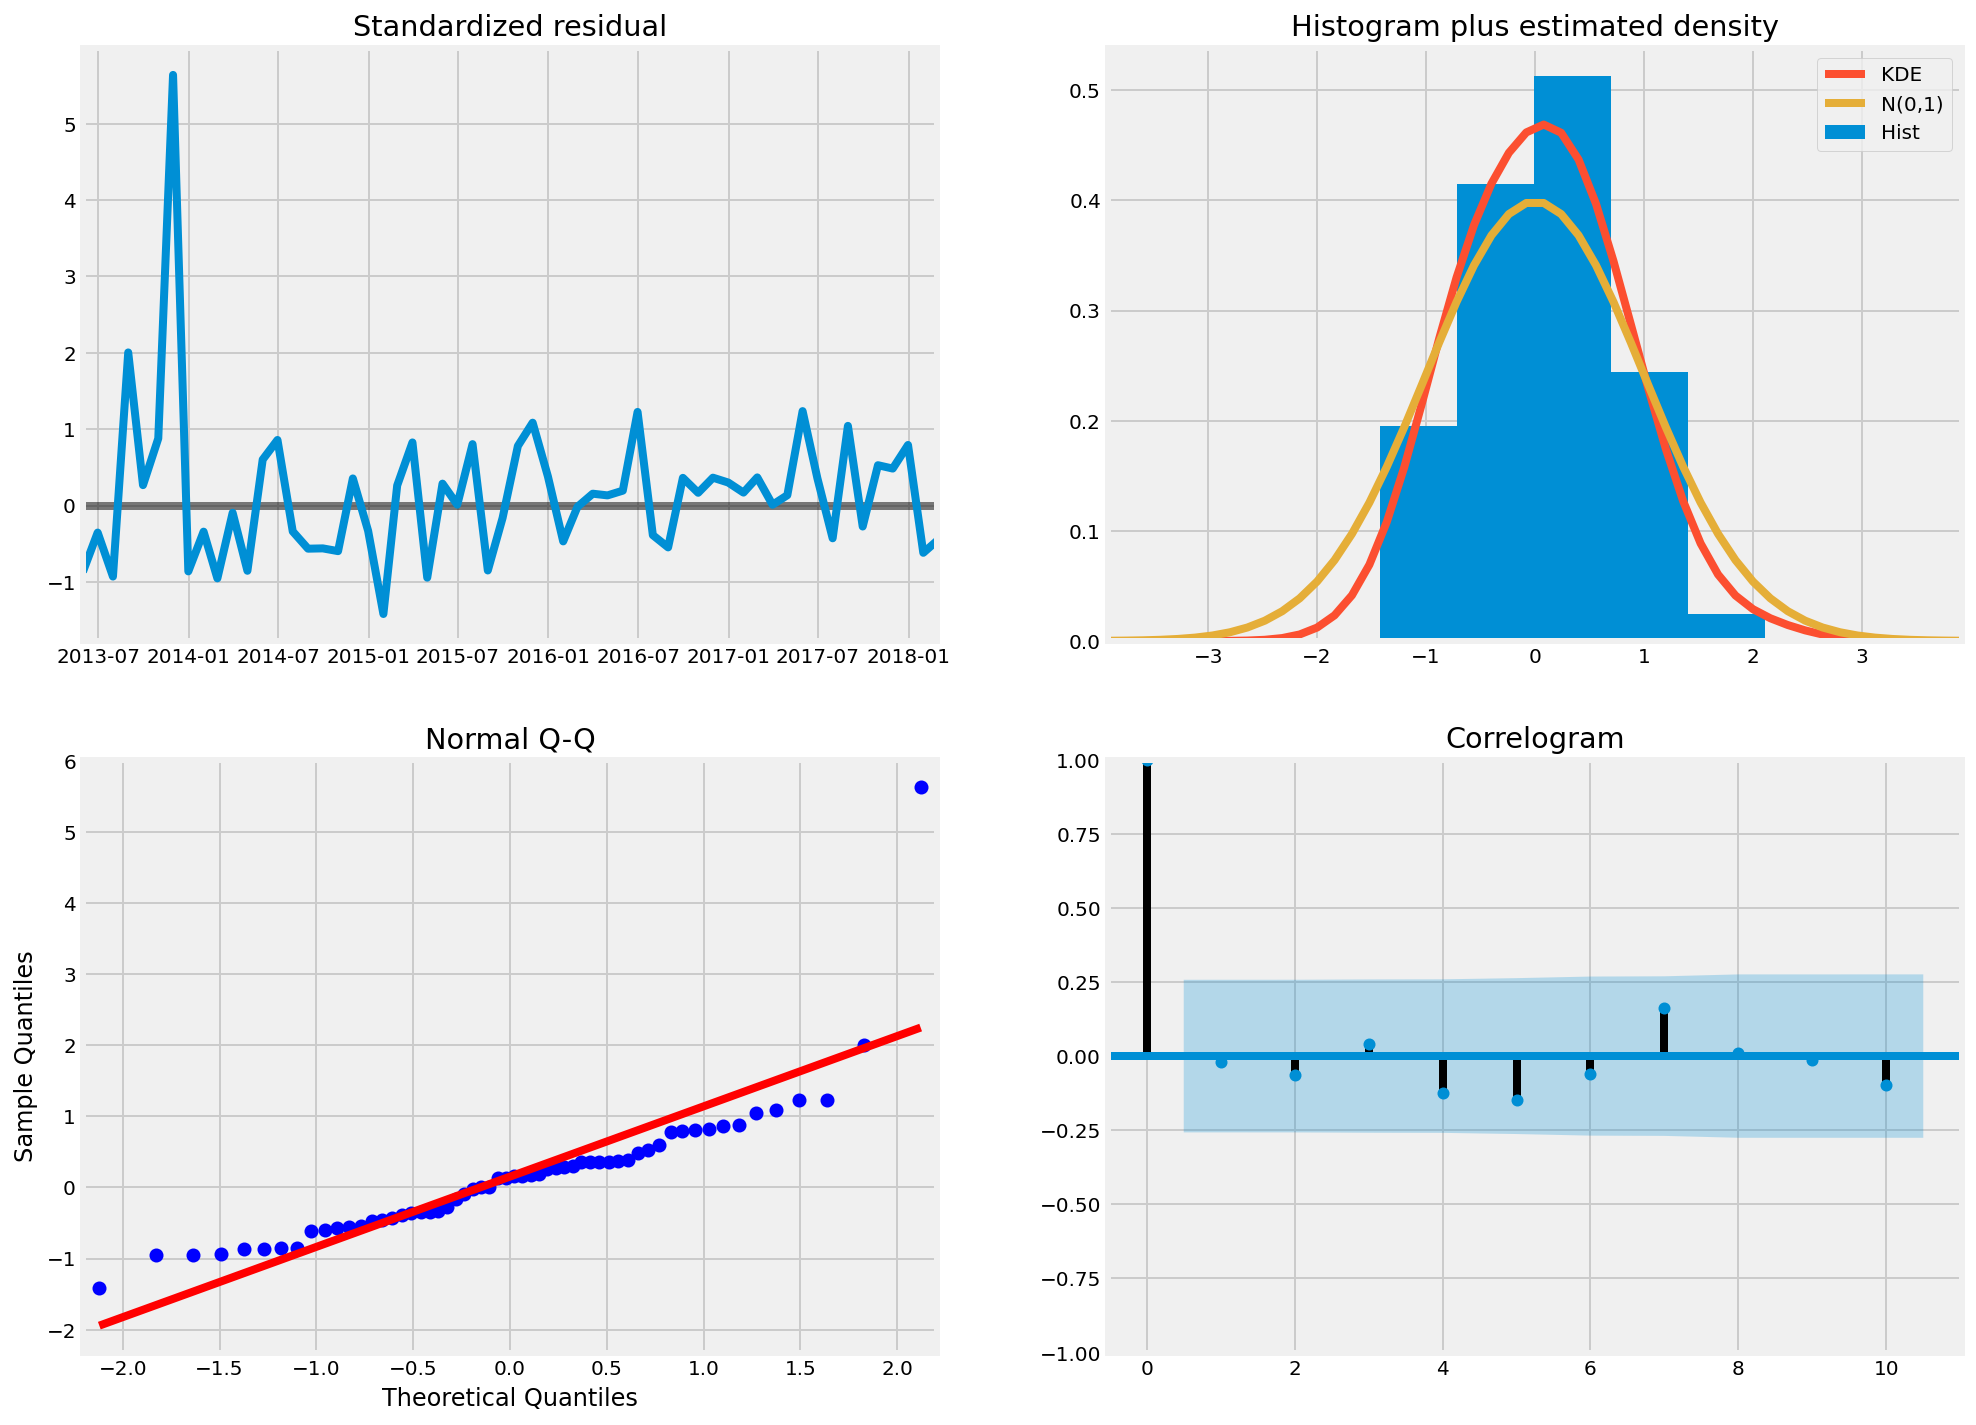

In [136]:
#running the model diagnostics functions and plotting its result [3]
mdl_bst.plot_diagnostics(figsize=(15, 12))
plt.show()

###Predictions

In [137]:
#using inverse Box-Cox transformation function[3]
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

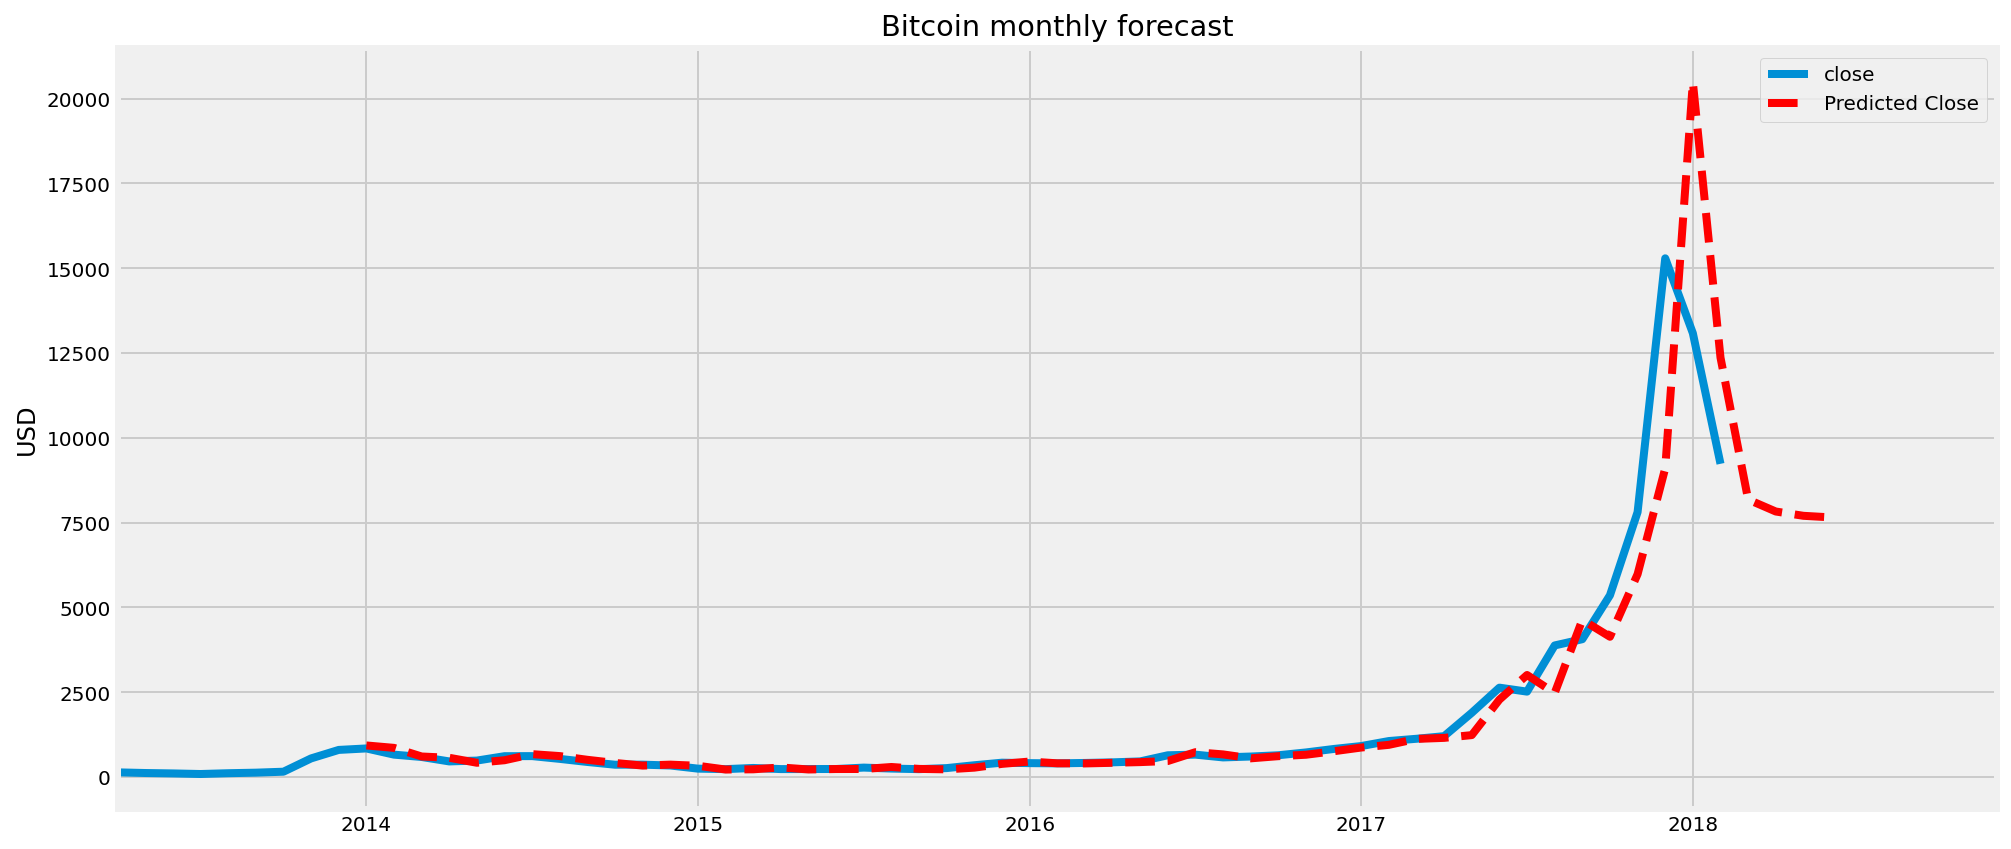

In [138]:
# predicting prices of Bitcoin's close values[3]
#storing the predictions into a new dataframe
bc_mth_pred = bc_mth[['close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
             datetime(2018, 11, 30), datetime(2018, 12, 31)]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= bc_mth.columns)
bc_mth_pred = pd.concat([bc_mth_pred, future])

#monthly forecasting of the values of Bitcoin's close prices
#bc_mth_pred['forecast'] = invboxcox(mdl_bst.predict(start=0, end=75), lmbda)
bc_mth_pred['forecast'] = invboxcox(mdl_bst.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


plt.figure(figsize=(15,7))
bc_mth_pred.close.plot()
bc_mth_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

##SARIMAX Model
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

#### Parameter Selection

The same process of parameter selection for seasonal ARIMA. For each combination we fit a new seasonal ARIMA model with SARIMAX() and assess its overall quality.

In [139]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
# SARIMAX have been tried for different seasonal periods - 12months, 6months, 4months and 3months
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 6)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
#        model = SARIMAX(bc_mth.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 3)).fit(disp=-1) 
    except ValueError:
        print('poor combination of parameters:', param)
        continue
    aic = model.aic
    if aic < aic_bst:
        mdl_bst = model
        aic_bst = aic
        params_bst = param
    rslt.append([param, model.aic])

In [140]:
#printing the best suited results of the models[1]
#new dataframe to store the results of the appropriate models
rslt_table = pd.DataFrame(rslt)
#creating two columns to print values accordingly
rslt_table.columns = ['parameters', 'aic']
#sorting of values based into the relevant columns
print(rslt_table.sort_values(by = 'aic', ascending=True).head())
print(mdl_bst.summary())

      parameters         aic
50  (2, 2, 1, 0) -164.332128
49  (2, 2, 0, 1) -163.652858
48  (2, 2, 0, 0) -163.094534
51  (2, 2, 1, 1) -162.484581
52  (2, 2, 2, 0) -162.467226
                                 Statespace Model Results                                 
Dep. Variable:                          close_box   No. Observations:                   59
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                  88.166
Date:                            Sun, 14 Aug 2022   AIC                           -164.332
Time:                                    22:10:11   BIC                           -153.360
Sample:                                04-30-2013   HQIC                          -160.222
                                     - 02-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

### Analysis of Results 

In [141]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p = %f" % adfuller(mdl_bst.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p = 0.006149


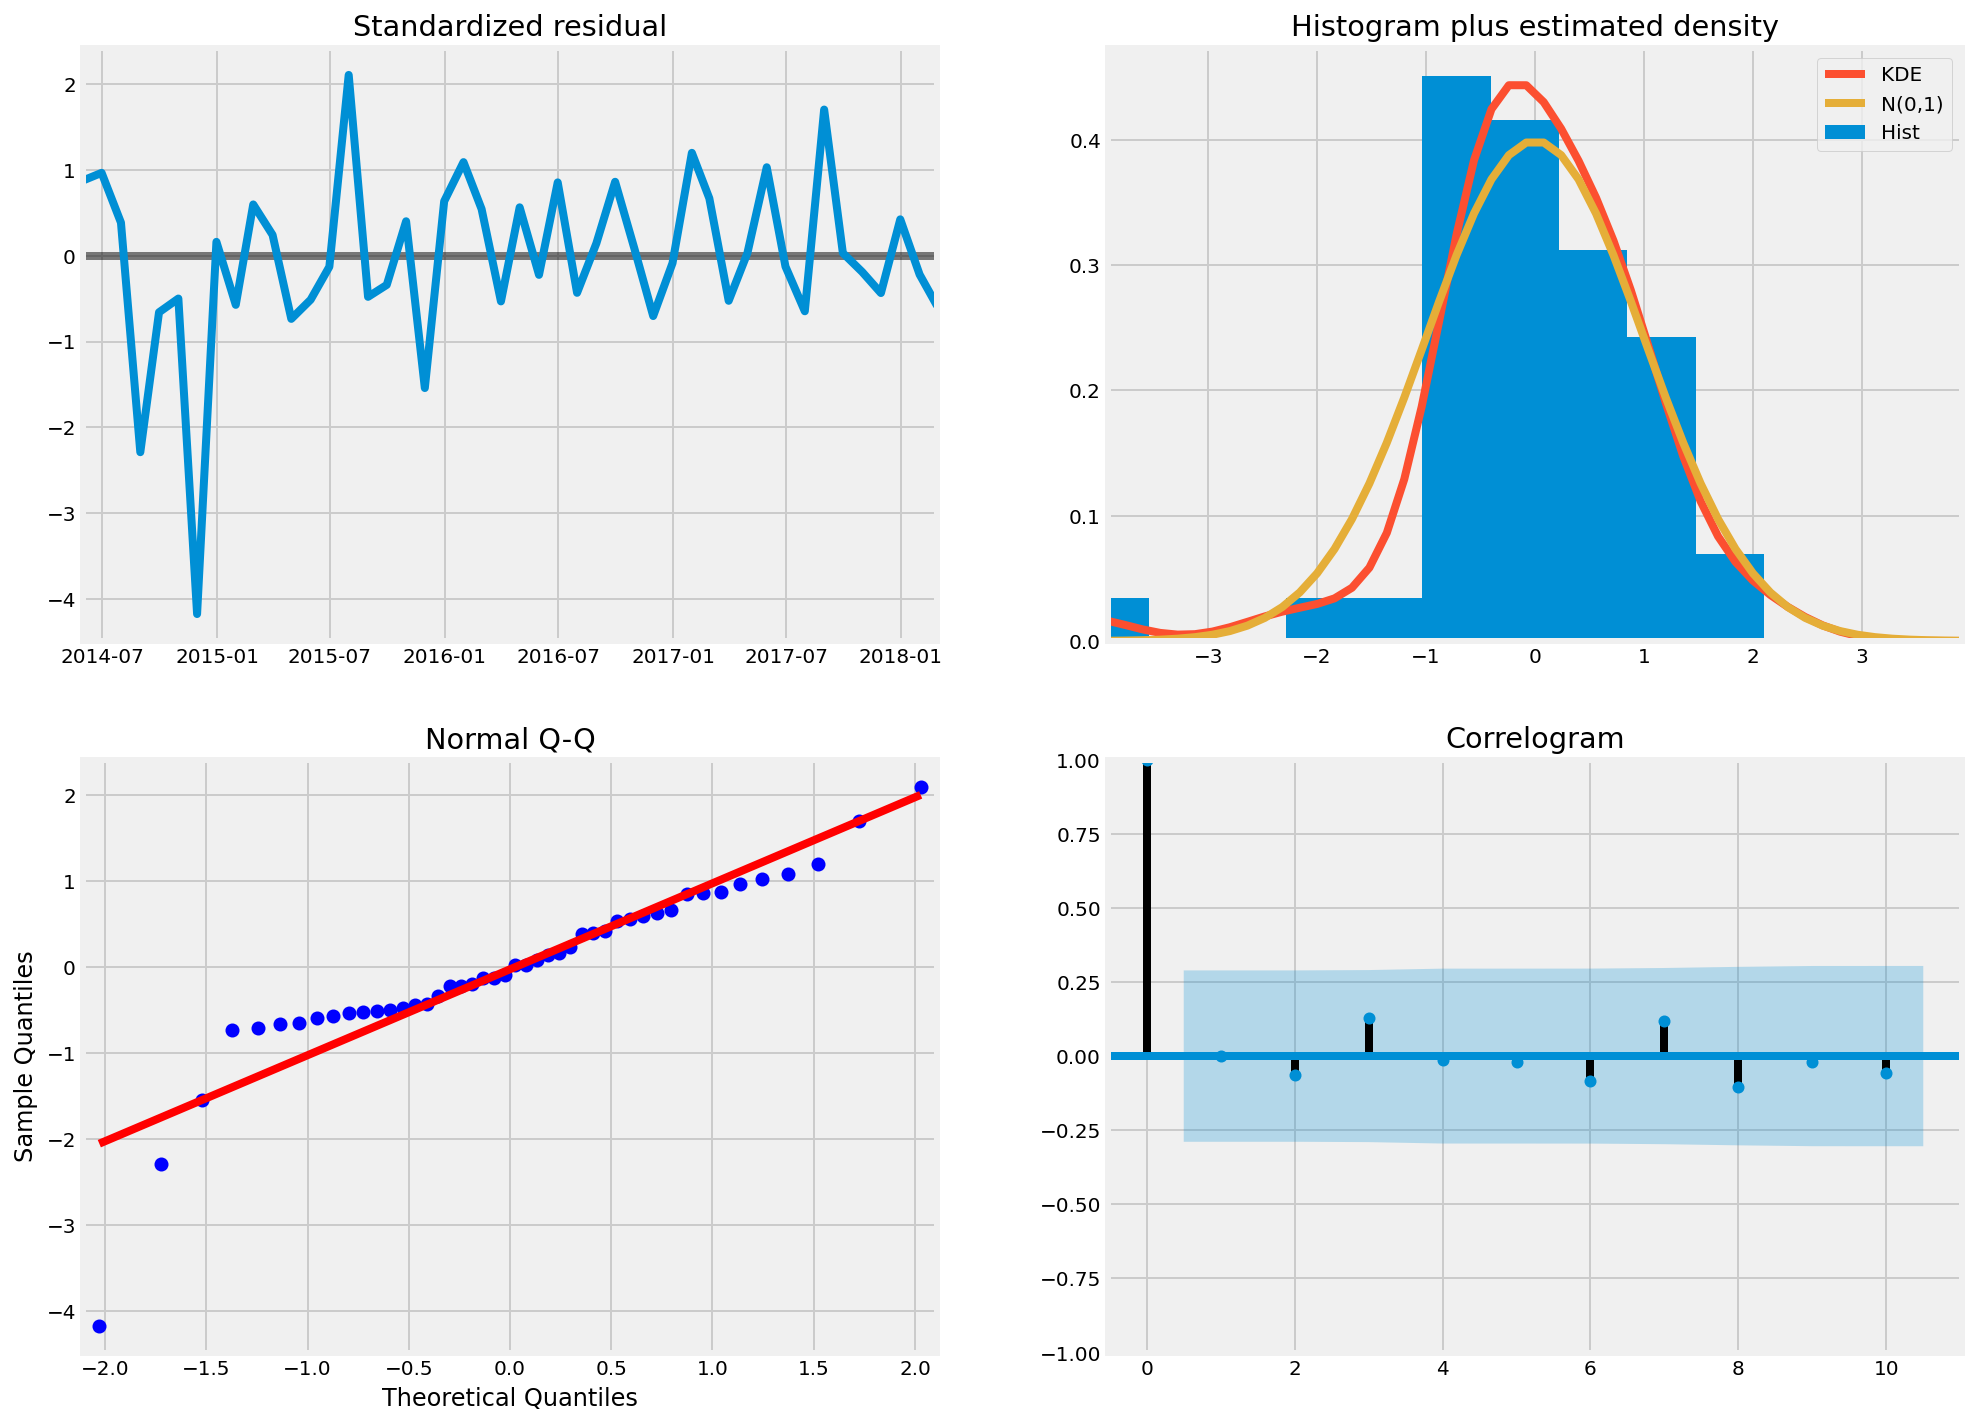

In [142]:
#running the model diagnostics functions and plotting its result [3]
mdl_bst.plot_diagnostics(figsize=(15, 12))
plt.show()

Augmented Dickey Fuller(ADF) test result:: p=0.006149


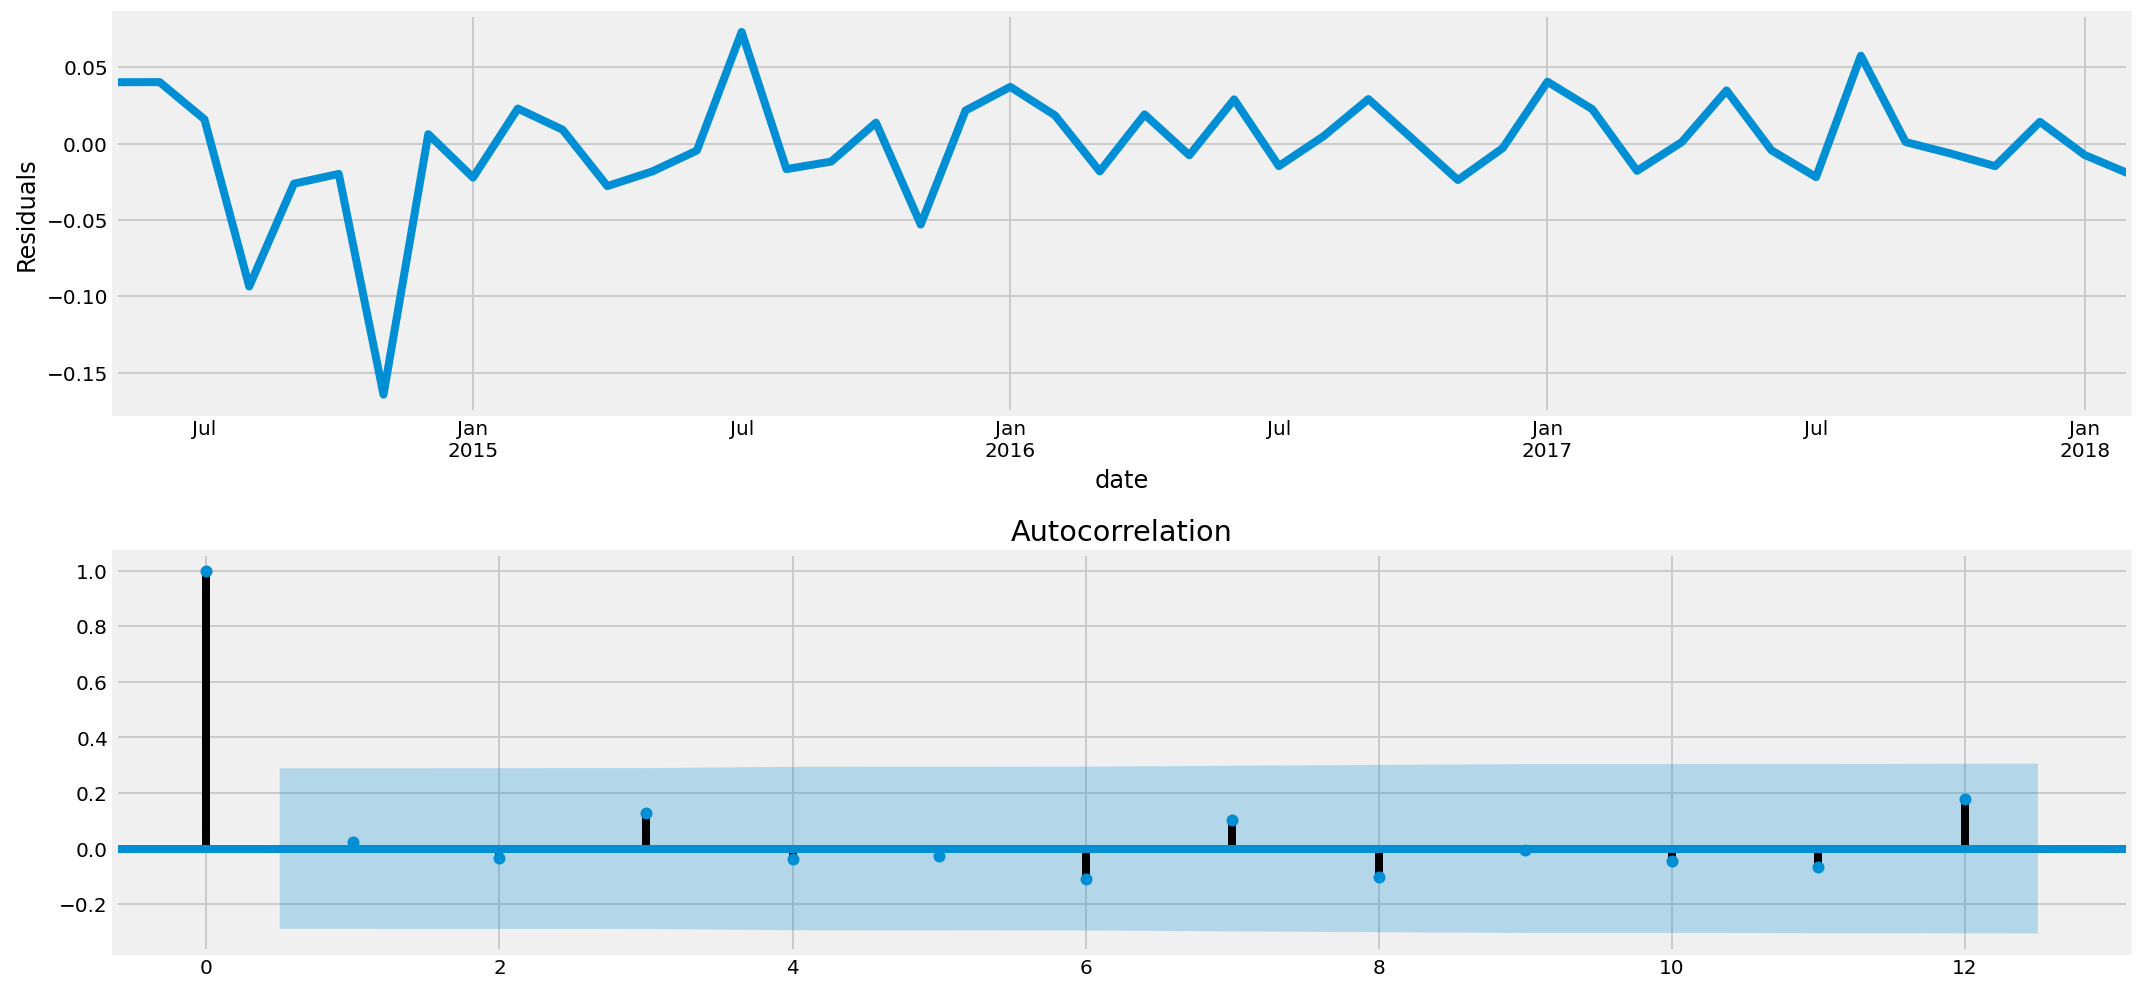

In [143]:
# Seasonal and Trend decomposition using Loess(STL) decomposition[1]
plt.figure(figsize=(15,7))
plt.subplot(211)
mdl_bst.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
plot_acf(mdl_bst.resid[13:].values.squeeze(), lags=12, ax=ax)

#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(mdl_bst.resid[13:])[1])

plt.tight_layout()
plt.show()

###Prediction

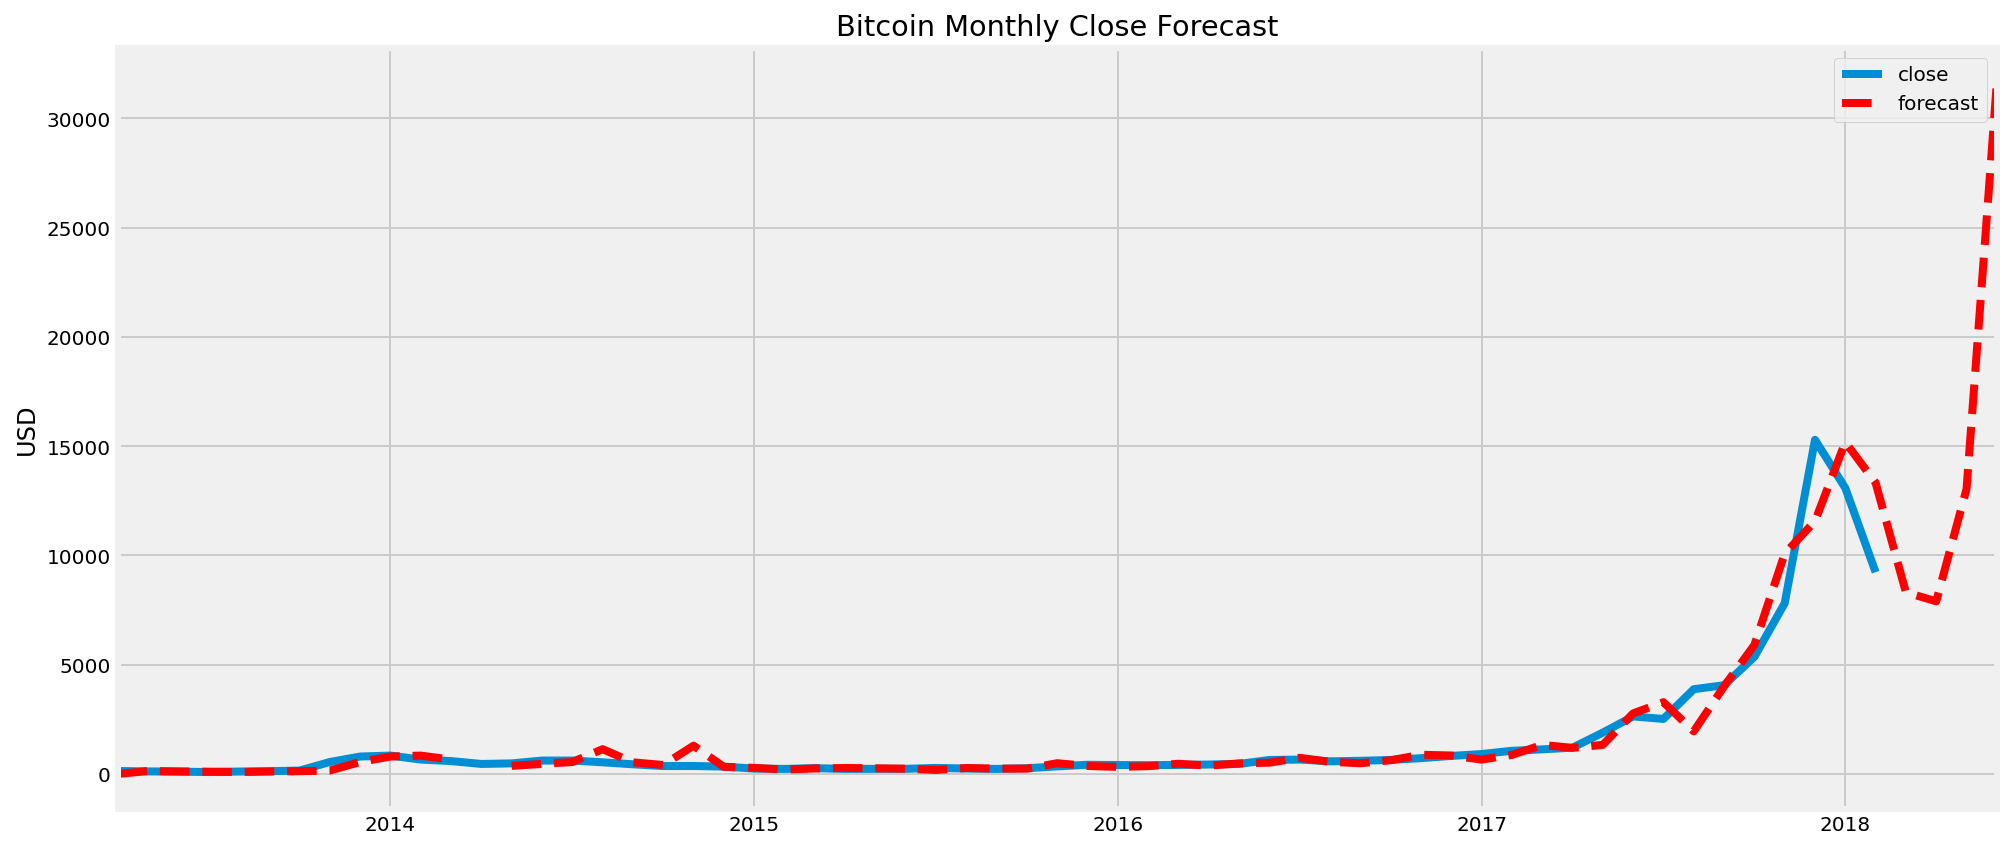

In [144]:
# predicting prices of Bitcoin's close values[3]
#storing the predictions into a new dataframe
# Bitcoin Price Predictions[1]
bc_mth2 = bc_mth[['close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]

#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= bc_mth.columns)
bc_mth2 = pd.concat([bc_mth2, future])

#monthly forecasting of the values of Bitcoin's close prices
bc_mth2['forecast'] = invboxcox(mdl_bst.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
bc_mth2.close.plot()
bc_mth2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

#**Evaluation**

A simple indicator of how accurate out forecast is is the root mean square error (RMSE).

In [145]:
#computing RMSE values[1]
#storing the forecasts into new variable
y_forecastd = bc_mth2.forecast
#storing the actual close price values
y_truth = bc_mth2['2015-01-01':'2017-01-01'].close

# implementing the root mean square error
rmse = np.sqrt(((y_forecastd - y_truth)**2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 68.99


References:

> 1 https://www.analyticsvidhya.com/blog/2021/12/cryptocurrency-price-prediction-using-arima-model/

> 2 https://www.kaggle.com/datasets/jessevent/all-crypto-currencies

> 3 https://www.kaggle.com/code/taniaj/cryptocurrency-predictions-with-arima/notebook

The major inspiration for building the ARIMA model has been taken from [1]. The additional details of executing the programme was facilitated by taking reference from [3]. The [3] was instrumental for the experimentation purspose as it allowed to alter the date_list and the SARIMAX() models for different seasonal periods. It can be observed by toggling the comments to observe the change in RMSE values.The dataset details can be obtained from [2] which is a publicaly available to users.